# Functions / Libraries

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
from fetchData import fetchdata 

In [3]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:\t\t",accuracy_score(y_test,result))
    print('Precision Score:\t', str(precision_score(y_test,result)))
    print('Recall Score:\t\t' + str(recall_score(y_test,result)))
    print("F1 Score:\t\t",f1_score(y_test, result, average='macro', zero_division=True))
    print(classification_report(y_test, result))
    

def valid(X_valid, y_valid, clf):
    clf.fit
    result = clf.predict(X_valid)
    print("Accuracy:",accuracy_score(result,y_valid))
    print(classification_report(y_valid, result))

def cv_events(data):
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()

    cv_pd_list = []
    for i, d in enumerate(EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df1, df2])
    return cv_pd_list

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [4]:
def scale_concat(data_list):
    scaler = StandardScaler()
    df = scaler.fit_transform(pd.concat(data_list, axis=1))
    return df

# Data

In [5]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
pheme_bert = fetchdata('pheme','bert')
pheme_thread =  fetchdata('pheme','thread')

ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
ext_bert = fetchdata('ext','bert')
ext_thread = fetchdata('ext','thread')

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')
rhi_bert = fetchdata('rhi','bert')

# pheme_all = pd.read_csv("./data/all/_PHEMEall.csv")
# ext_all = pd.read_csv("./data/all/_PHEMEextall.csv")

# temp = pd.read_csv('./data/previous/data_notembeded.csv')
# pd.concat([pheme_sparse, pheme_event])

In [30]:
pheme_thread = pheme_thread.replace(-np.inf, 0)
ext_thread = ext_thread.replace(-np.inf, 0)

In [10]:
# cv = cv_events(pd.concat([pheme_sparse, pheme_event], axis=1))
cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))

# Feature Importance on Sparse Features

Feature ranking:
1. feature 21: capital_ratio (0.046487)
2. feature 23: listed_count (0.045595)
3. feature 22: tweet_count (0.044854)
4. feature 25: follow_ratio (0.043432)
5. feature 24: friends_count (0.038014)
6. feature 17: word_count (0.037747)
7. feature 2: Verb (0.037098)
8. feature 1: Noun (0.036460)
9. feature 16: char_count (0.035815)
10. feature 9: Numeral (0.034910)
11. feature 3: Adjective (0.034259)
12. feature 29: AVG WordCount (0.033035)
13. feature 15: HashTag (0.032760)
14. feature 12: Determiner (0.032642)
15. feature 10: Conjunction_inj (0.032559)
16. feature 33: AVG Url (0.032452)
17. feature 34: AVG Mention (0.032250)
18. feature 27: SUM FriendsCount (0.032232)
19. feature 28: AVG FriendsCount (0.031801)
20. feature 32: Percent HashTag (0.030974)
21. feature 31: SUM HashTag (0.030434)
22. feature 30: AVG HashTag (0.029737)
23. feature 0: URLcount (0.026713)
24. feature 8: Adverb (0.025446)
25. feature 4: Pronoun (0.022452)
26. feature 5: FirstPersonPronoun (0.0213

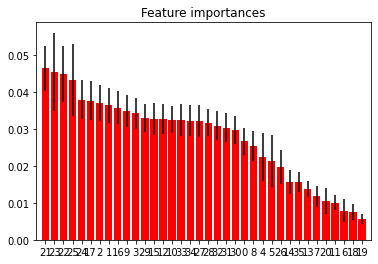

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
scaler = StandardScaler()
X = scaler.fit_transform(pheme_sparse)
X2 = scaler.fit_transform(pheme_thread)

X = pd.concat([pheme_sparse, pheme_thread], axis=1)

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=3)

forest.fit(X, pheme_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Thread

In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(pheme_thread.values)
X_test = scaler.fit_transform(ext_thread.values)

In [46]:
clf = SVC()
train_test(X_train, X_test, pheme_y, ext_y, clf)

# Accuracy:		 0.6268041237113402
# Precision Score:	 0.7596685082872928
# Recall Score:		0.7452574525745257
# F1 Score:		 0.49753590255796776

Accuracy:		 0.24123711340206186
Precision Score:	 1.0
Recall Score:		0.0027100271002710027
F1 Score:		 0.19603603603603603
              precision    recall  f1-score   support

           0       0.24      1.00      0.39       116
           1       1.00      0.00      0.01       369

    accuracy                           0.24       485
   macro avg       0.62      0.50      0.20       485
weighted avg       0.82      0.24      0.10       485



# Sparse

## Data

In [74]:
scaler = StandardScaler()
pheme_sparse_scaled = scaler.fit_transform(pheme_sparse.values)
ext_sparse_scaled = scaler.fit_transform(ext_sparse.values)

## CLF

In [76]:
clf = SVC(gamma='auto')
train_test(pheme_sparse_scaled, ext_sparse_scaled, pheme_y, ext_y, clf)

Accuracy:		 0.3463917525773196
Precision Score:	 0.9193548387096774
Recall Score:		0.15447154471544716
F1 Score:		 0.3381875002690382
              precision    recall  f1-score   support

           0       0.26      0.96      0.41       116
           1       0.92      0.15      0.26       369

    accuracy                           0.35       485
   macro avg       0.59      0.56      0.34       485
weighted avg       0.76      0.35      0.30       485



In [77]:
clf = GaussianNB()
train_test(pheme_sparse_scaled, ext_sparse_scaled, pheme_y, ext_y, clf)

Accuracy:		 0.5917525773195876
Precision Score:	 0.8577405857740585
Recall Score:		0.5555555555555556
F1 Score:		 0.5636903896481535
              precision    recall  f1-score   support

           0       0.33      0.71      0.45       116
           1       0.86      0.56      0.67       369

    accuracy                           0.59       485
   macro avg       0.60      0.63      0.56       485
weighted avg       0.73      0.59      0.62       485



## SPARSE - PHEME CV

In [37]:
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target
clf = SVC(gamma='auto')
train_test(X, val_X, y, val_y, clf)
# valid(rhi, rhi_y, clf)

Accuracy:		 0.47191011235955055
Precision Score:	 0.0
Recall Score:		0.0
F1 Score:		 0.32061068702290074
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       420
           1       0.00      0.00      0.00       470

    accuracy                           0.47       890
   macro avg       0.24      0.50      0.32       890
weighted avg       0.22      0.47      0.30       890



/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/june/m

# Sparse + W2V

## Data

In [41]:
scaler = StandardScaler()
df = scaler.fit_transform(pheme_sparse.values)
sparse_w2v = np.concatenate([df, pheme_AVGw2v.values],axis=1)
df = scaler.fit_transform(ext_sparse.values)
sparse_w2v_ext = np.concatenate([df, ext_AVGw2v.values],axis=1)

## CLF

In [42]:
clf = SVC(gamma='auto')
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.32989690721649484
Precision Score:	 0.9782608695652174
Recall Score:		0.12195121951219512
F1 Score:		 0.31564094214696625
              precision    recall  f1-score   support

           0       0.26      0.99      0.41       116
           1       0.98      0.12      0.22       369

    accuracy                           0.33       485
   macro avg       0.62      0.56      0.32       485
weighted avg       0.81      0.33      0.26       485



In [45]:
clf = GaussianNB()
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.4
Precision Score:	 0.9148936170212766
Recall Score:		0.23306233062330622
F1 Score:		 0.3987628918680588
              precision    recall  f1-score   support

           0       0.28      0.93      0.43       116
           1       0.91      0.23      0.37       369

    accuracy                           0.40       485
   macro avg       0.60      0.58      0.40       485
weighted avg       0.76      0.40      0.38       485



# BERT

## Data

In [17]:
# pheme_y.head()
pheme_bert.head()

,BERTEmbed_0,BERTEmbed_1,BERTEmbed_2,BERTEmbed_3,BERTEmbed_4,BERTEmbed_5,BERTEmbed_6,BERTEmbed_7,BERTEmbed_8,BERTEmbed_9,...,BERTEmbed_758,BERTEmbed_759,BERTEmbed_760,BERTEmbed_761,BERTEmbed_762,BERTEmbed_763,BERTEmbed_764,BERTEmbed_765,BERTEmbed_766,BERTEmbed_767
0,0.299457,0.198897,-0.491295,0.211787,0.197080,0.234026,0.200608,-0.096086,0.250423,0.266876,...,0.209932,-0.166056,0.245046,-0.580443,-0.141690,0.222918,-0.144328,0.048243,-0.027414,-0.055394
1,0.299628,0.207495,-0.491100,0.207046,0.198606,0.223802,0.201070,-0.085390,0.272306,0.276768,...,0.227522,-0.168281,0.246145,-0.575933,-0.133583,0.210461,-0.141031,0.049042,-0.035745,-0.065774
2,0.300907,0.193260,-0.498778,0.215972,0.193097,0.223985,0.181815,-0.106533,0.247362,0.262557,...,0.210722,-0.168287,0.242233,-0.579043,-0.142183,0.223372,-0.142068,0.043969,-0.031963,-0.054336
3,0.294519,0.198307,-0.492020,0.211912,0.201571,0.225530,0.192947,-0.100199,0.261141,0.264648,...,0.216593,-0.163219,0.242032,-0.586569,-0.137623,0.219293,-0.139870,0.039641,-0.034909,-0.062468
4,0.296625,0.196416,-0.493361,0.214012,0.195244,0.231359,0.194209,-0.101270,0.252890,0.263173,...,0.211895,-0.166441,0.237079,-0.587006,-0.140724,0.224566,-0.142844,0.041942,-0.030708,-0.056173


## CLF

In [72]:
clf = SVC(gamma='auto')
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.5917525773195876
Precision Score:	 0.7697160883280757
Recall Score:		0.6612466124661247
F1 Score:		 0.5070935818995606
              precision    recall  f1-score   support

           0       0.26      0.37      0.30       116
           1       0.77      0.66      0.71       369

    accuracy                           0.59       485
   macro avg       0.51      0.52      0.51       485
weighted avg       0.65      0.59      0.61       485



In [83]:
clf = GaussianNB()
train_test(pheme_bert, ext_bert, pheme_y, ext_y, clf)

Accuracy:		 0.6268041237113402
Precision Score:	 0.7596685082872928
Recall Score:		0.7452574525745257
F1 Score:		 0.49753590255796776
              precision    recall  f1-score   support

           0       0.24      0.25      0.24       116
           1       0.76      0.75      0.75       369

    accuracy                           0.63       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.63      0.63      0.63       485



# W2V

## Data

## CLF

In [84]:
clf = SVC(gamma='auto')
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.32989690721649484
Precision Score:	 0.9782608695652174
Recall Score:		0.12195121951219512
F1 Score:		 0.31564094214696625
              precision    recall  f1-score   support

           0       0.26      0.99      0.41       116
           1       0.98      0.12      0.22       369

    accuracy                           0.33       485
   macro avg       0.62      0.56      0.32       485
weighted avg       0.81      0.33      0.26       485



In [85]:
clf = GaussianNB()
train_test(sparse_w2v, sparse_w2v_ext, pheme_y, ext_y, clf)

Accuracy:		 0.4
Precision Score:	 0.9148936170212766
Recall Score:		0.23306233062330622
F1 Score:		 0.3987628918680588
              precision    recall  f1-score   support

           0       0.28      0.93      0.43       116
           1       0.91      0.23      0.37       369

    accuracy                           0.40       485
   macro avg       0.60      0.58      0.40       485
weighted avg       0.76      0.40      0.38       485



# BERT + SPARSE

## Data

In [38]:
scaler = StandardScaler()
df = scaler.fit_transform(pheme_sparse.values)
df2 = scaler.fit_transform(pheme_thread.values)
sparse_bert = np.concatenate([df, df2, pheme_bert.values],axis=1)
df = scaler.fit_transform(ext_sparse.values)
df2 = scaler.fit_transform(ext_thread.values)
sparse_bert_ext = np.concatenate([df, df2, ext_bert.values],axis=1)

## CLF

In [39]:
clf = SVC(gamma='auto')
train_test(sparse_bert, sparse_bert_ext, pheme_y, ext_y, clf)

Accuracy:		 0.4350515463917526
Precision Score:	 0.8925619834710744
Recall Score:		0.2926829268292683
F1 Score:		 0.43499149659863945
              precision    recall  f1-score   support

           0       0.28      0.89      0.43       116
           1       0.89      0.29      0.44       369

    accuracy                           0.44       485
   macro avg       0.59      0.59      0.43       485
weighted avg       0.75      0.44      0.44       485



In [37]:
clf = GaussianNB()
train_test(sparse_bert, sparse_bert_ext, pheme_y, ext_y, clf)

# Accuracy:		 0.6268041237113402
# Precision Score:	 0.7596685082872928
# Recall Score:		0.7452574525745257
# F1 Score:		 0.49753590255796776

Accuracy:		 0.6268041237113402
Precision Score:	 0.7596685082872928
Recall Score:		0.7452574525745257
F1 Score:		 0.49753590255796776
              precision    recall  f1-score   support

           0       0.24      0.25      0.24       116
           1       0.76      0.75      0.75       369

    accuracy                           0.63       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.63      0.63      0.63       485



In [13]:
X = scale_concat([pheme_sparse, pheme_bert])
X2 = scale_concat([ext_sparse, ext_bert])
clf = GaussianNB()
train_test(X, sparse_bert_ext, pheme_y, ext_y, clf)

Accuracy:		 0.6536082474226804
Precision Score:	 0.7570332480818415
Recall Score:		0.8021680216802168
F1 Score:		 0.48947368421052634
              precision    recall  f1-score   support

           0       0.22      0.18      0.20       116
           1       0.76      0.80      0.78       369

    accuracy                           0.65       485
   macro avg       0.49      0.49      0.49       485
weighted avg       0.63      0.65      0.64       485



In [35]:
X = scale_concat([pheme_sparse, pheme_bert, pheme_thread])
X2 = scale_concat([ext_sparse, ext_bert, ext_thread])
clf = SVC()
train_test(X, X2, pheme_y, ext_y, clf)

Accuracy:		 0.5051546391752577
Precision Score:	 0.8028169014084507
Recall Score:		0.4634146341463415
F1 Score:		 0.4845360824742268
              precision    recall  f1-score   support

           0       0.27      0.64      0.38       116
           1       0.80      0.46      0.59       369

    accuracy                           0.51       485
   macro avg       0.54      0.55      0.48       485
weighted avg       0.68      0.51      0.54       485

